In [105]:
%pylab inline
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Loading the data

In [106]:
card_df = pd.read_csv("Dataset\creditcard.csv")
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Features V1 to V28 are unidentifiable and are hidden to protect the user's identity and security purposes.

Class 1 - Fraudulent transactions, Class 0 - Otherwise

### Data Exploration

In [107]:
len(card_df.index)

284807

In [108]:
print(card_df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [109]:
card_df.drop_duplicates(subset=None,keep='first',inplace=True)

In [110]:
card_df.shape

(283726, 31)

Percentage of fradulent transactions in data.: 0.1667101358352777


<AxesSubplot:xlabel='Class', ylabel='count'>

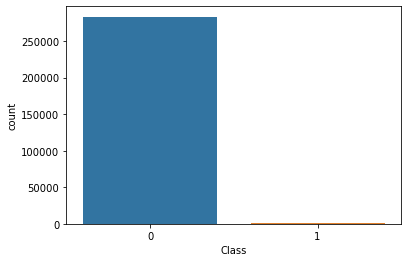

In [111]:
print('Percentage of fradulent transactions in data.:',card_df.Class.mean()*100)
sns.countplot(card_df.Class)

We find that the data is higly imbalanced, fradulent transactions are only 0.17% as compared to non-fradulent transactions. 
Any classifier on this data will give high accuracy!

#### Feature Exploration

<AxesSubplot:xlabel='Time', ylabel='Density'>

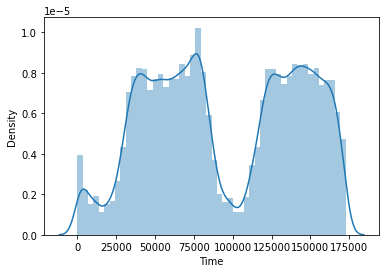

In [112]:
sns.distplot(card_df.Time)

Since Time is not affecting the transactions , we drop the variable

In [113]:
card_df.drop('Time',axis=1,inplace=True)

<AxesSubplot:xlabel='Amount'>

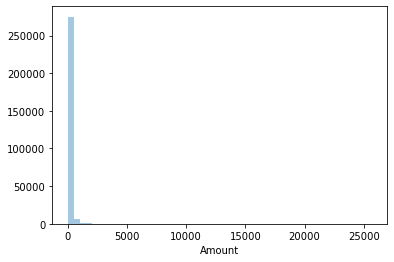

In [114]:
sns.distplot(card_df.Amount,kde=False)

Very few transactions of higher value, lower value dominates the data, so we will have to normalise the data

In [115]:
card_df['amt_normalize'] = ((card_df.Amount) - (card_df.Amount.mean()))/(card_df.Amount.std())

In [116]:
card_df1 = card_df.copy()
y = card_df.Class
X = card_df.drop(columns =['Class','Amount'])

#### Train and test data

In [117]:
X_org = X #saving original data for future
y_org = y
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=123)

#### Model fitting

In [118]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)

In [119]:
print("accuracy on the training set:",logreg.score(X_train, y_train))

# check the accuracy on the test dataset
print("accuracy on the testing set:",logreg.score(X_test, y_test))

accuracy on the training set: 0.9991898830064809
accuracy on the testing set: 0.9991776140126027


In [120]:
predicted = logreg.predict(X_train)
# Confusion Matrix for train data
print('Confusion Matrix on train data')
print(confusion_matrix(predicted, y_train))

# Predict class labels for the test dataset
predicted_test = logreg.predict(X_test)
# Confusion Matrix for test data
print('Confusion Matrix on test data')
print(confusion_matrix(predicted_test, y_test))

print("\nClassification report")
print(classification_report(predicted_test, y_test))

Confusion Matrix on train data
[[189755    125]
 [    29    187]]
Confusion Matrix on test data
[[93457    65]
 [   12    96]]

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93522
           1       0.60      0.89      0.71       108

    accuracy                           1.00     93630
   macro avg       0.80      0.94      0.86     93630
weighted avg       1.00      1.00      1.00     93630



Since the confusion matrix for both test and training data is similar, there is no overfitting.

Since accuracy is not the best criteria and we need to minimize the fraudulent transactions, we focus on <b>recall, precision and F1score</b>  

Here <b> recall-83%, precison - 61%, F1 score - 70%</b>

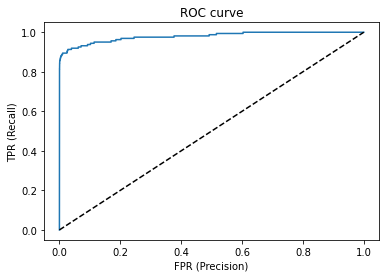

Area under curve (AUC):  0.9788751164650266


In [121]:
#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

*Though AUC is high, but model is not predicting the fraudulent transactions well! AUC is high bcs of imbalanced data*

### Techniques to cater for imbalanced data

#### Cross validation

In [122]:
# on training data
scores = cross_val_score(logreg, X_train, y_train,cv=10)
y_pred = cross_val_predict(logreg, X_train, y_train, cv=10)

print("Confusion matrix")
print(confusion_matrix(y_train,y_pred))

print("Accuracy on tarining set",scores.mean())

Confusion matrix
[[189753     31]
 [   127    185]]
Accuracy on tarining set 0.9991688429985641


In [123]:
# on test data
scores_t = cross_val_score(logreg, X_test, y_test,cv=10)
y_pred_t = cross_val_predict(logreg, X_test, y_test, cv=10)

print("Confusion matrix")
print(confusion_matrix(y_test,y_pred_t))

print("Accuracy on tarining set",scores_t.mean())

Confusion matrix
[[93455    14]
 [   66    95]]
Accuracy on tarining set 0.9991455730001068


In [124]:
print("Classification report")
print(classification_report(y_pred_t,y_test))

Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93521
           1       0.59      0.87      0.70       109

    accuracy                           1.00     93630
   macro avg       0.79      0.94      0.85     93630
weighted avg       1.00      1.00      1.00     93630



<b> recall - 87%, precision-59%, f1score - 70%</b>

#### Oversampling using SMOTE

In [125]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X= X_org
y= y_org
X_res, y_res = sm.fit_resample(X, y)

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=0)

In [126]:
logreg = LogisticRegression()

In [127]:
logreg.fit(X_train,y_train)

LogisticRegression()

accuracy on the testing set: 0.9444280999427646
[[90844  7987]
 [ 2402 85714]]
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     98831
           1       0.91      0.97      0.94     88116

    accuracy                           0.94    186947
   macro avg       0.94      0.95      0.94    186947
weighted avg       0.95      0.94      0.94    186947



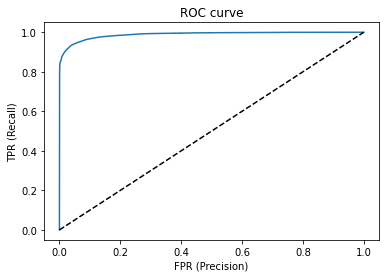

Area under curve (AUC):  0.9884193042547851


In [128]:
print("accuracy on the testing set:",logreg.score(X_test, y_test))

# Predict class labels for the test set
predicted = logreg.predict(X_test)

# Confusion Matrix for train data
print(confusion_matrix(predicted, y_test))

print(classification_report(predicted, y_test))

#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-97%, precision-91%, f1score-94% </b>

#### Ensemble Modeling(Random Forest)

In [129]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [130]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
model_rf = rf.fit(X_train, y_train)

AUC = 0.9466897326327476
Accuracy = 0.9995621061625547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93485
           1       0.96      0.75      0.84       145

    accuracy                           1.00     93630
   macro avg       0.98      0.88      0.92     93630
weighted avg       1.00      1.00      1.00     93630



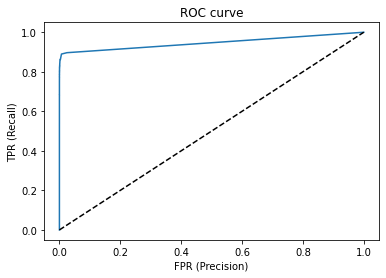

Area under curve (AUC):  0.9466897326327476


In [131]:
predicted_rf = model_rf.predict(X_test)
probs_rf = model_rf.predict_proba(X_test)
print('AUC =', roc_auc_score(y_test, probs_rf[:, 1]))
print('Accuracy =', accuracy_score(y_test, predicted_rf))
print(classification_report(y_test, predicted_rf))

#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = model_rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-75%, Precison-96%, F1score-84% </b>

#### Bagging

In [132]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93530
           1       0.57      0.82      0.67       100

    accuracy                           1.00     93630
   macro avg       0.78      0.91      0.83     93630
weighted avg       1.00      1.00      1.00     93630

Accuracy = 0.9991348926626081


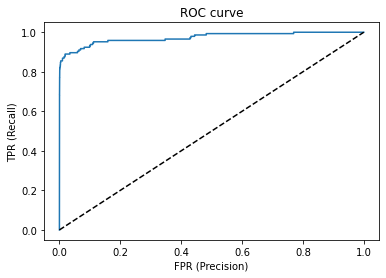

Area under curve (AUC):  0.9730477874931069


In [133]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
num_trees = 100
model = BaggingClassifier(LogisticRegression())
model.fit(X_train, y_train)

#test set
predicted = model.predict(X_test)
print(classification_report(predicted, y_test))
print('Accuracy =', accuracy_score(y_test, predicted))

from sklearn.metrics import roc_curve, auc
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> Recall- 82%, Precison-57%, F1score - 67%</b> 

#### Boosting(XG Boost)

In [134]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

accuracy on the testing set: 0.9995514258250561
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93505
           1       0.79      0.91      0.84       125

    accuracy                           1.00     93630
   macro avg       0.89      0.96      0.92     93630
weighted avg       1.00      1.00      1.00     93630



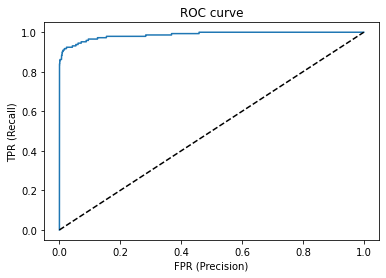

Area under curve (AUC):  0.9868276489128811


In [135]:
from xgboost import XGBClassifier
model2 = XGBClassifier(objective='reg:logistic')
model2.fit(X_train, y_train)

y_pred1 = model2.predict(X_test)
# check the accuracy on the test dataset
print("accuracy on the testing set:",model2.score(X_test, y_test))
print(classification_report(y_pred1, y_test))

#ROC, AUC
from sklearn.metrics import roc_curve, auc
y_score = model2.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR (Precision)')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-91%, precision-79%, f1score-84%</b>

#### Boosting(ADABoost)

In [136]:
X= X_org
y= y_org

#  Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [137]:
from sklearn.ensemble import AdaBoostClassifier
boost = AdaBoostClassifier()

[[93456    29]
 [   48    97]]
accuracy on the testing set: 0.9991776140126027
Accuracy = 0.9991776140126027
              precision    recall  f1-score   support

           0  0.99948665 0.99968979 0.99958821     93485
           1  0.76984127 0.66896552 0.71586716       145

    accuracy                      0.99917761     93630
   macro avg  0.88466396 0.83432765 0.85772768     93630
weighted avg  0.99913101 0.99917761 0.99914883     93630

[0.4187341  0.29190541 0.27945337 ... 0.43666197 0.43751819 0.45280498]


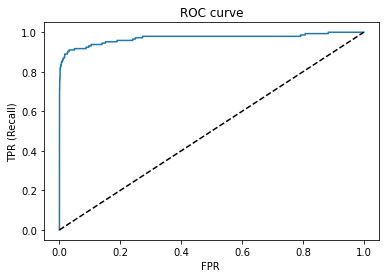

Area under curve (AUC):  0.9704281527739098


In [138]:
boost.fit(X_train, y_train)
y_pred_boost = boost.predict(X_test)
print(confusion_matrix( y_test,y_pred_boost))
print("accuracy on the testing set:",boost.score(X_test, y_test))
print('Accuracy =', accuracy_score(y_test, y_pred_boost))
print(classification_report(y_test,y_pred_boost,digits=8))

from sklearn.metrics import roc_curve, auc
y_score = boost.predict_proba(X_test)[:,1]
print(y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)

title('ROC curve')
xlabel('FPR ')
ylabel('TPR (Recall)')

plot(fpr,tpr)
plot((0,1), ls='dashed',color='black')
plt.show()
print('Area under curve (AUC): ', auc(fpr,tpr))

<b> recall-66%, precision-76%, F1score-71% </b>

#### Results:

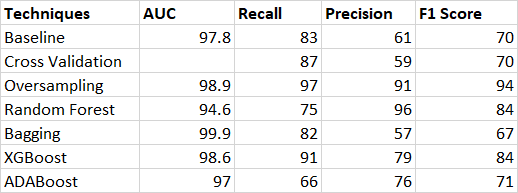

Out of all the methods, oversampling(SMOTE) has the highest recall, precision and F1score.